In [1]:
import numpy as np
import pandas as pd
from scipy import fftpack, stats
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)

/home/can/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Train

In [2]:
# Load the data
df = pd.read_json('./data/train.json')
# Create Data
X_train, y_train = [], []
for im_band1, im_band2, label in zip(df['band_1'], df['band_2'], df['is_iceberg']):
    X_train.append(im_band1 + im_band2)
    y_train.append(label)    
X_train = np.array(X_train)
y_train = np.array(y_train)
print 'X_train.shape:', X_train.shape
print 'y_train.shape:', y_train.shape

X_train.shape: (1604, 11250)
y_train.shape: (1604,)


Text(0.5,1,u'Image FFT2')

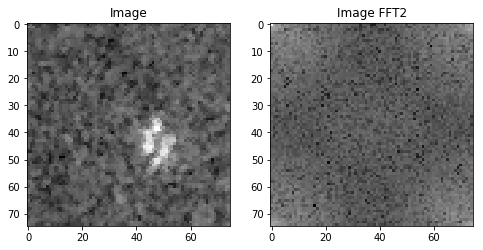

In [3]:
im = X_train[500, :75*75].reshape(75, 75)
# Plot
fig = plt.figure(figsize=(8, 4))
plt.subplot(1,2,1); plt.imshow(im, cmap='gray'); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(np.log(np.abs(fftpack.fft2(im))), cmap='gray'); plt.title('Image FFT2')

-16.545046
-15.005393
-25.046721
-12.146865
-23.610939


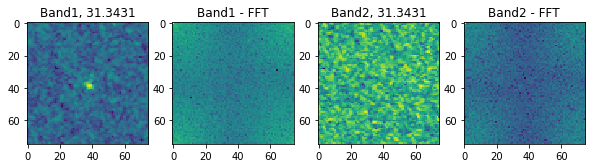

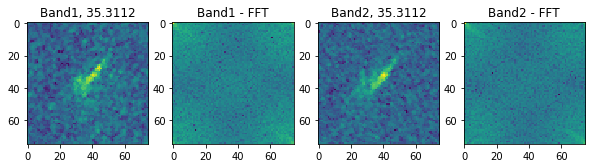

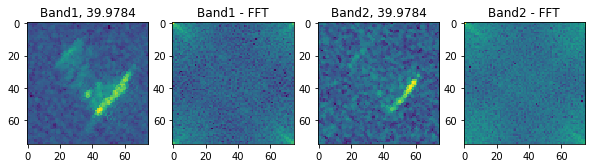

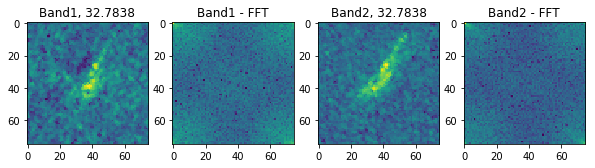

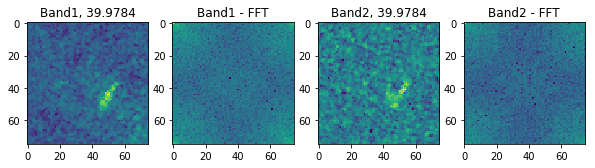

In [4]:
# Iceberg images
N_sample = 5
df_ = df[df['is_iceberg'] == 1].sample(N_sample, random_state=RANDOM_SEED)
for im_band1, im_band2, angle in zip(df_['band_1'], df_['band_2'], df_['inc_angle']): 
    # Get images
    im_band1 = np.array(im_band1).reshape(75, 75)
    im_band2 = np.array(im_band2).reshape(75, 75)
    print np.median(im_band1)
    # Get fft2
    im_band1_fft = np.log(np.abs(fftpack.fft2(im_band1)))
    im_band2_fft = np.log(np.abs(fftpack.fft2(im_band2)))    
    # Plot
    fig = plt.figure(figsize=(10, 6))
    plt.subplot(1,4,1); plt.imshow(im_band1); plt.title('Band1, ' + str(angle))
    plt.subplot(1,4,2); plt.imshow(im_band1_fft); plt.title('Band1 - FFT')
    plt.subplot(1,4,3); plt.imshow(im_band2); plt.title('Band2, ' + str(angle))
    plt.subplot(1,4,4); plt.imshow(im_band2_fft); plt.title('Band2 - FFT')

-30.588961
-24.85421
-20.0389
-20.253181
-17.695692


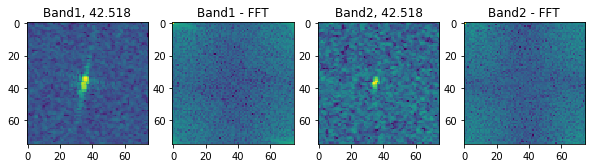

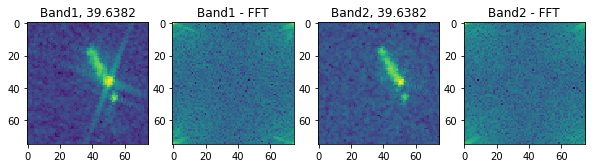

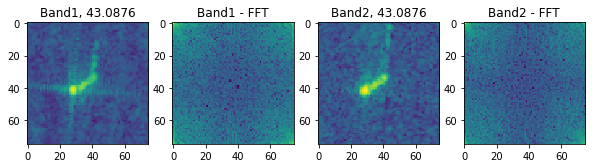

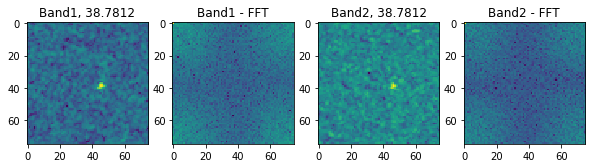

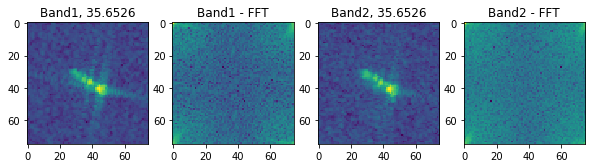

In [5]:
# Ship images
N_sample = 5
df_ = df[df['is_iceberg'] == 0].sample(N_sample, random_state=RANDOM_SEED)
for im_band1, im_band2, angle in zip(df_['band_1'], df_['band_2'], df_['inc_angle']):  
    # Get images
    im_band1 = np.array(im_band1).reshape(75, 75)
    im_band2 = np.array(im_band2).reshape(75, 75)
    print np.median(im_band1)
    # Get fft2
    im_band1_fft = np.log(np.abs(fftpack.fft2(im_band1)))
    im_band2_fft = np.log(np.abs(fftpack.fft2(im_band2))) 
    # Plot
    fig = plt.figure(figsize=(10, 6))
    plt.subplot(1,4,1); plt.imshow(im_band1); plt.title('Band1, ' + str(angle))
    plt.subplot(1,4,2); plt.imshow(im_band1_fft); plt.title('Band1 - FFT')
    plt.subplot(1,4,3); plt.imshow(im_band2); plt.title('Band2, ' + str(angle))
    plt.subplot(1,4,4); plt.imshow(im_band2_fft); plt.title('Band2 - FFT')

In [6]:
def get_stat_f(im):
    f = []
    f += [stats.skew(im)]
    f += [stats.kurtosis(im)]
    f += [np.mean(im)]
    f += [np.median(im)]
    f += [np.min(im)]
    f += [np.max(im)]
    f += [np.std(im)]
    return np.array(f)

def get_f(im_band1, im_band2):
    """
    im_band1, im_band2 are list from df
    """    
    # Stat features
    f_stat1 = get_stat_f(im_band1)
    f_stat2 = get_stat_f(im_band2)
    f_stat = np.concatenate([f_stat1, f_stat2])
    
    # Fourier
    im_band1 = np.array(im_band1).reshape(75, 75)
    im_band2 = np.array(im_band2).reshape(75, 75)    
    im_band1_fft = np.log(np.abs(fftpack.fft2(im_band1))).flatten()
    im_band2_fft = np.log(np.abs(fftpack.fft2(im_band2))).flatten()    
    f_fft = np.concatenate([im_band1_fft, im_band2_fft])
    
    # Merge
    f = np.concatenate([f_stat, f_fft])    
    
    return f

In [7]:
# Create training data
X_train, y_train = [], []
for im_band1, im_band2, label in tqdm_notebook(zip(df['band_1'], df['band_2'], df['is_iceberg'])):
    f = get_f(im_band1, im_band2)
    X_train.append(f)
    y_train.append(label)    
X_train = np.array(X_train)
y_train = np.array(y_train)
print 'X_train.shape:', X_train.shape
print 'y_train.shape:', y_train.shape

A Jupyter Widget


X_train.shape: (1604, 11264)
y_train.shape: (1604,)


In [16]:
# PCA
N_dims = 16

# Make model
pca_model = PCA(n_components=N_dims, whiten=False, random_state=RANDOM_SEED)
estimator_model = xgb.XGBClassifier(max_depth=6,
                                    n_estimators=64)
steps = [pca_model, estimator_model]
model = make_pipeline(*steps)

In [17]:
result = cross_validate(model, X_train, y_train, scoring='neg_log_loss', cv=5)
result

{'fit_time': array([ 0.46776295,  0.45208383,  0.45159602,  0.44647503,  0.44544196]),
 'score_time': array([ 0.01725197,  0.01378512,  0.01376295,  0.09007812,  0.01363397]),
 'test_score': array([-0.25367505, -0.29437271, -0.28684811, -0.27174307, -0.26138273]),
 'train_score': array([-0.09981448, -0.09663924, -0.08991381, -0.08940042, -0.09100274])}

In [18]:
np.mean(result['test_score'])

-0.27360433378767918

In [11]:
# Create the model
model.fit(X_train, y_train)
model

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=16, random_state=43,
  svd_solver='auto', tol=0.0, whiten=True)), ('xgbclassifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=64, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

# Predict Test

In [12]:
df_test = pd.read_json('./data/test.json')
# Create Data
X_test = []
for im_band1, im_band2 in tqdm_notebook(zip(df_test['band_1'], df_test['band_2'])):
    f = get_f(im_band1, im_band2)
    X_test.append(f)
X_test = np.array(X_test)
print 'X_test.shape:', X_test.shape

A Jupyter Widget


X_test.shape: (8424, 11264)


In [13]:
y_test_p = model.predict_proba(X_test)[:, 1]
print y_test_p.shape

(8424,)


In [14]:
df_sub = pd.DataFrame()
df_sub['id'] = df_test['id']
df_sub['is_iceberg'] = y_test_p

In [15]:
df_sub.to_csv('./submissions/sub5.csv', index=False)